# Analisi dello spettro di immagini radar (timeseries)

In [1]:
import numpy as np
import scipy.fft
import scipy.signal
import matplotlib.pyplot as plt

from common import get_experiment_names, load_experiment, declutter

In [2]:
rpm_base_folder_path, rpm_names = get_experiment_names('SR250Mate', 'rpm-ladder', subject='M', antenna='rx0')
recovery_base_folder_path, recovery_names = get_experiment_names('SR250Mate', 'recovery', antenna='rx0')

for name in recovery_names:
    print(name)

print()

for name in rpm_names:
    print(name)

Millenial_M_recovery_20250526-180201_sr250_rx0.npy

MillenIAls_M_rpm-ladder_120rpm_20250526-173448_sr250_rx0.npy
MillenIAls_M_rpm-ladder_60rpm_20250526-173230_sr250_rx0.npy
MillenIAls_M_rpm-ladder_40rpm_20250526-173138_sr250_rx0.npy
MillenIAls_M_rpm-ladder_100rpm_20250526-173404_sr250_rx0.npy
MillenIAls_M_rpm-ladder_80rpm_20250526-173319_sr250_rx0.npy


In [3]:
# modifica questa linea per caricare l'esperimento rilevante
raw = load_experiment(rpm_base_folder_path, 'MillenIAls_M_rpm-ladder_40rpm_20250526-173138_sr250_rx0.npy')

In [4]:
# per generare un asse delle frequenze in BPM
samples_per_window = raw.shape[0]
samples_per_second = 20 # hardcoded from logger.py
seconds_per_window = samples_per_window / samples_per_second

base_frequency = 1.0 / seconds_per_window
frequency_range_hz = np.arange(raw.shape[0]) * base_frequency
frequency_range_bpm = 60 * frequency_range_hz

bpm = frequency_range_bpm

## Variation on fourier analysis
  * fft on raw radar data (no DC bias)
  * fft on energy (no DC bias)
  * fft on energy after declutter
  * fft2d on raw radar data (no DC bias)

In [5]:
#         | raw | declutter |
# ------- + --- | --------- |
# complex |     |           |
# energy  |     |           |
#
# "raw" o "declutter" intende il preprocessing da fare sul dato
# "complex" o "energy" descrive se trattare il dato come numero complesso o considerare solo il modulo

raw_complex = raw
raw_energy = np.abs(raw)
declutter_complex = declutter(raw)
declutter_energy = np.abs(declutter_complex)

In [6]:
p_raw_complex = np.abs(scipy.fft.fft(raw_complex, axis=0))
p_raw_energy = np.abs(scipy.fft.fft(raw_energy, axis=0))
p_declutter_complex = np.abs(scipy.fft.fft(declutter_complex, axis=0))
p_declutter_energy = np.abs(scipy.fft.fft(declutter_energy, axis=0))

# rimuovo la componente dc dello spettro così da migliorare la visualizzazione
p_raw_complex[0] = 0
p_raw_energy[0] = 0
p_declutter_complex[0] = 0
p_declutter_energy[0] = 0

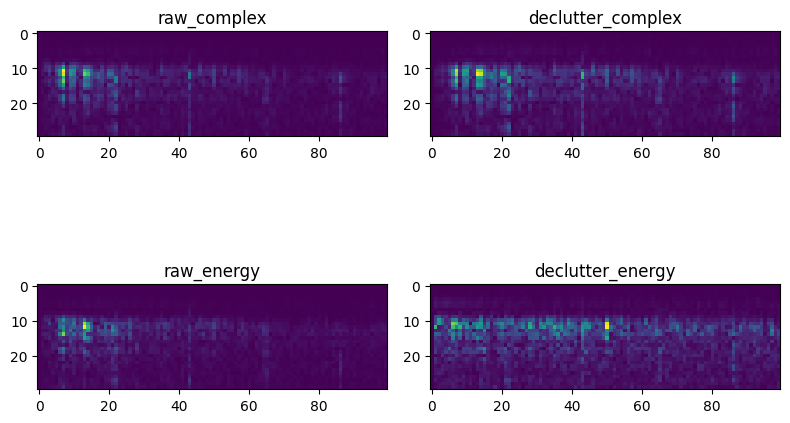

In [7]:
# questo per fare uno zoom sulla parte interessante e avere figure un po' più grandi
nbins = 30
nfreq = 100

fig, ax = plt.subplots(2,2, figsize=(8,6))

ax[0,0].set_title('raw_complex')
ax[0,0].imshow(p_raw_complex.T[:nbins, :nfreq])
ax[1,0].set_title('raw_energy')
ax[1,0].imshow(p_raw_energy.T[:nbins, :nfreq])
ax[0,1].set_title('declutter_complex')
ax[0,1].imshow(p_declutter_complex.T[:nbins, :nfreq])
ax[1,1].set_title('declutter_energy')
ax[1,1].imshow(p_declutter_energy.T[:nbins, :nfreq])

plt.tight_layout()
plt.show()

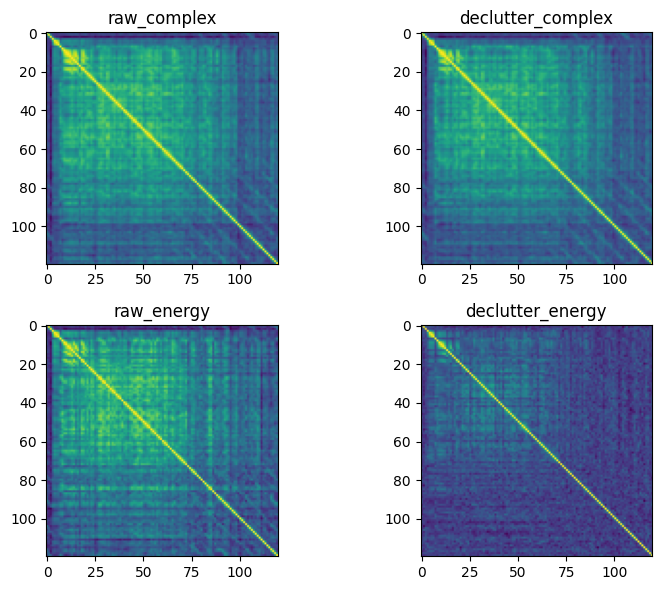

In [8]:
fig, ax = plt.subplots(2,2, figsize=(8,6))

ax[0,0].set_title('raw_complex')
ax[0,0].imshow(np.corrcoef(p_raw_complex, rowvar=False))
ax[1,0].set_title('raw_energy')
ax[1,0].imshow(np.corrcoef(p_raw_energy, rowvar=False))
ax[0,1].set_title('declutter_complex')
ax[0,1].imshow(np.corrcoef(p_declutter_complex, rowvar=False))
ax[1,1].set_title('declutter_energy')
ax[1,1].imshow(np.corrcoef(p_declutter_energy, rowvar=False))

plt.tight_layout()
plt.show()

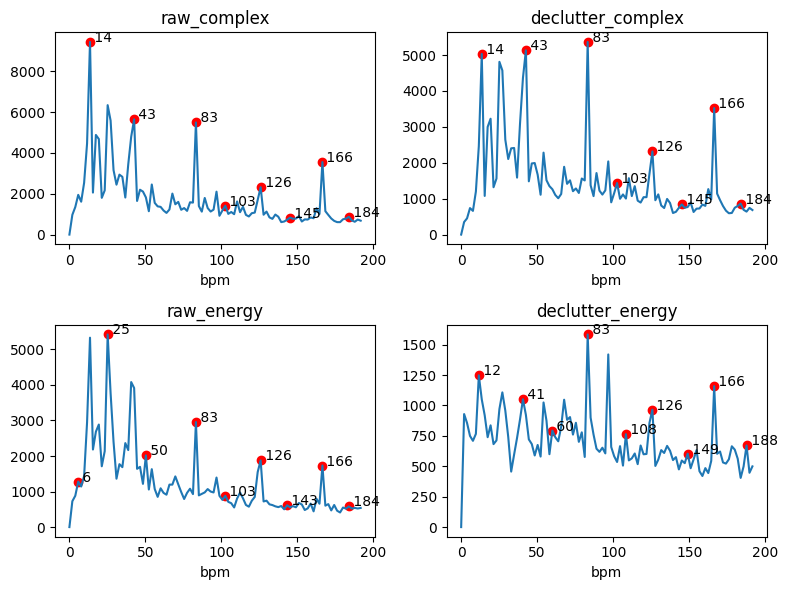

In [9]:
# cerchiamo di comprimere gli spettri e plottarli su uno stesso grafico
min_bin_idx = 10
max_bin_idx = 30
nfreq = 100


def plot_with_peaks(power, title: str, ax, distance=9):
    compressed = np.mean(power, axis=1)
    peaks, _ = scipy.signal.find_peaks(compressed, distance=distance)

    ax.set_title(title)
    ax.plot(bpm[:nfreq], compressed[:nfreq])

    for peak in peaks:
        if peak < nfreq:
            ax.scatter(bpm[peak], compressed[peak], c='r')
            ax.text(bpm[peak], compressed[peak], f'{bpm[peak]: .0f}')

    ax.set_xlabel('bpm')


fig, ax = plt.subplots(2,2, figsize=(8,6))
plot_with_peaks(p_raw_complex      , 'raw_complex'      , ax[0,0])
plot_with_peaks(p_raw_energy       , 'raw_energy'       , ax[1,0])
plot_with_peaks(p_declutter_complex, 'declutter_complex', ax[0,1])
plot_with_peaks(p_declutter_energy , 'declutter_energy' , ax[1,1])

plt.tight_layout()
plt.show()

Quale di questi spettri è il più informativo? Duro a stabilirsi ad occhio nudo. Potrei provare molte misure cercando le frequenze che mi aspetto di vedere.

In ogni caso questa è una piccola dimostrazione, questi spettri non verranno impiegati in contesto applicativo. Servono soltanto per instillare consapevolezza sul fatto che il processing sul dato di input potrebbe avere ripercussioni sulla qualità (*validation error*, per essere precisi) del modello ML.